In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import style
import random
import numpy.linalg as la
import scipy.io.wavfile
from scipy.signal import stft

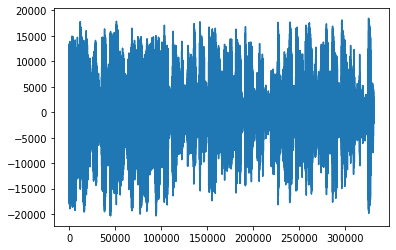

1291.9921875
(1293,)


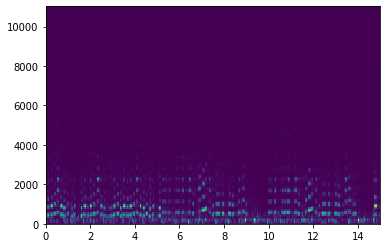

In [47]:
# Load the file and convert to floating point
number_music_files = 60
number_sound_files = 60
window_size = 256

sampleRate, data = scipy.io.wavfile.read(f'./Data/SpeechMusic/music/{1}.wav')
length = data.shape[0] / sampleRate
window_time = window_size / sampleRate
number_windows = length / window_time


data = s.astype(float)
plt.plot(data)
plt.show()

f, t, Zxx = stft(data, sampleRate, nperseg=window_size, noverlap=0)
print(number_windows)
print(t.shape)
plt.pcolormesh(t, f, np.abs(Zxx))
plt.show()

In [41]:
length = data.shape[0] / sampleRate
print(data.shape[0])
print(f"sampleRate = {sampleRate}")
print(f"length = {length}s")

330750
sampleRate = 22050
length = 15.0s
